# Automatic Music Mixer - Feature Testing
Aaron Collinsworth

### Inspiration
For the automatic music mixer, I am choosing to use a nearest neighbor system to find similar songs in a library that can be mixed at various points within them. Inspiration was found from "The sound of AI" channel on youtube, where a similar project named "Infinite Remixer" as demonstrated and explained thoroughly. Link below:

https://www.youtube.com/watch?v=zHdn0QgZPGY

https://github.com/musikalkemist/infiniteremixer

After borrowing some of his tools from github I was able to modify my own code to accept different inputs for features in order to test their effectiveness.
A few features were experimented with and finally combined together.

### Features

#### Chromagram
The first feature I will discuss is the chromagram. The chromagram are a spectral feature that are created using a Fourier transformation. The transformation converts the time domain signal into the frequency domain. This particular feature is able to capture melodic and harmonic aspects of an audio signal. An example plot of the fourier transformation as well as the chroma transformation are shown below:

In [24]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

sample_rate = 22050

signal, sr = librosa.load("Chase_and_Status-Heartbeat.mp3")
S = np.abs(librosa.stft(signal))
chromogram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)

In [26]:
def plot_chromagram(chroma, S):
    
    fig, ax = plt.subplots(figsize=(20, 10), nrows=2, sharex=True)

    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[0])

    fig.colorbar(img, ax=[ax[0]])

    ax[0].label_outer()

    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
    fig.colorbar(img, ax=[ax[1]])

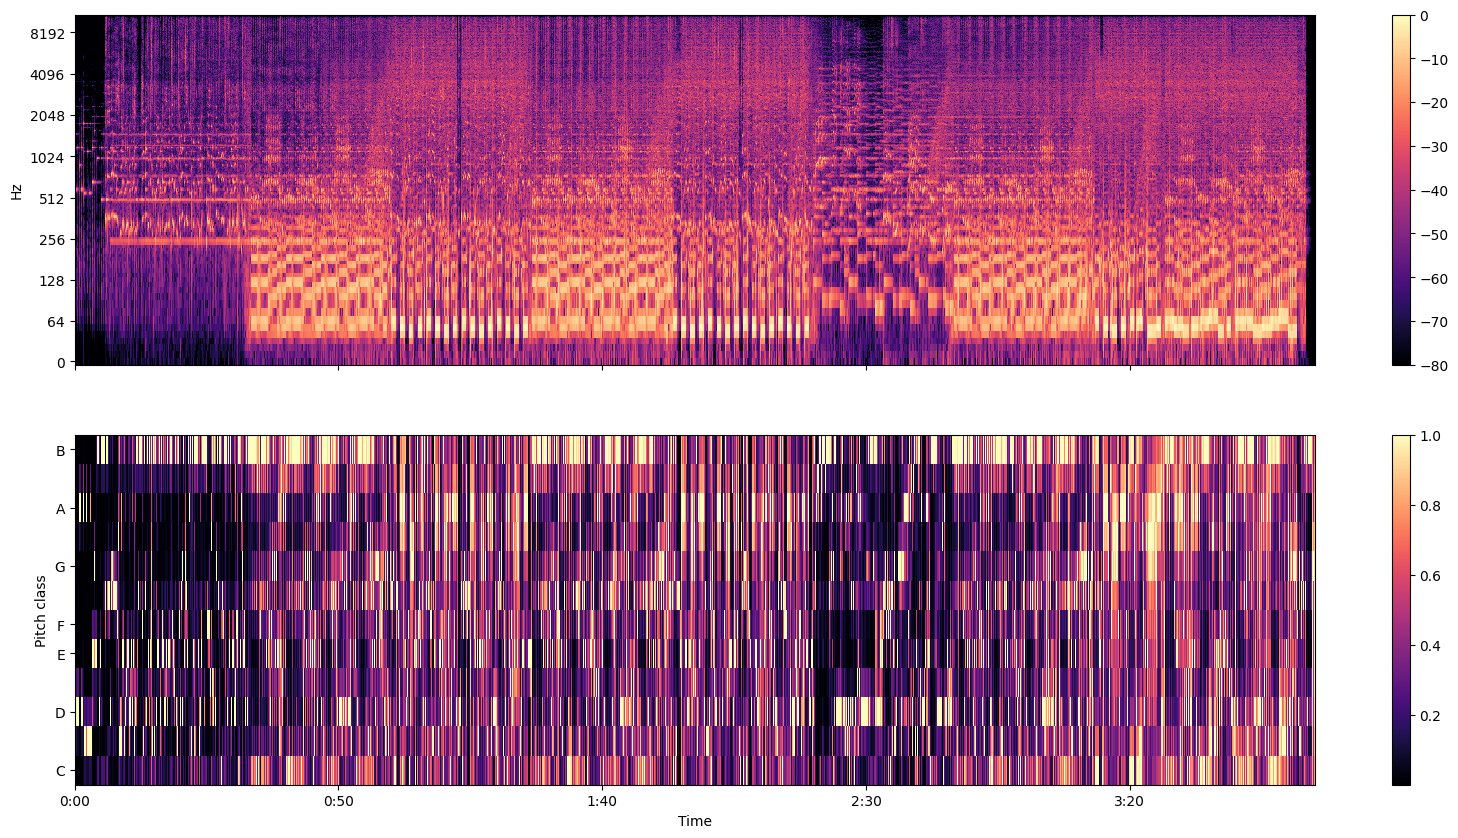

In [27]:
plot_chromagram(chromogram, S)

The chroma transformation takes the frequency of the fourier transform plot and bins them into the note frequencies. These transformations are able to capture the pitches of each note and used in conjunction with the model, can detect melody similarities.

#### Mel Frequency Ceptral Coefficients

Mel Frequency Ceptral Coefficients are a little bit more complicated. Essentially a Fourier transformation is taken of the alrady fourier transformed signal, transforming it into a completetly new domain. The new demain is called "Cepstral", which is a play on words of Spectral. The MFCC transformation is able to give information related to the timbral aspects of the sound. Timbre refers to the intensity of a pitch, and is able to capture emotion and loudness of a signal. The MFCC transformation is shown below: 

In [28]:
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)

In [43]:
def plot_mfcc(mfccs, S):

    fig, ax = plt.subplots(figsize=(20, 10), nrows=2, sharex=True)
    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                x_axis='time', y_axis='mel', fmax=8000,
                                ax=ax[0])

    fig.colorbar(img, ax=[ax[0]])

    ax[0].set(title='Mel spectrogram')

    ax[0].label_outer()

    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])

    fig.colorbar(img, ax=[ax[1]])

    ax[1].set(title='MFCC')

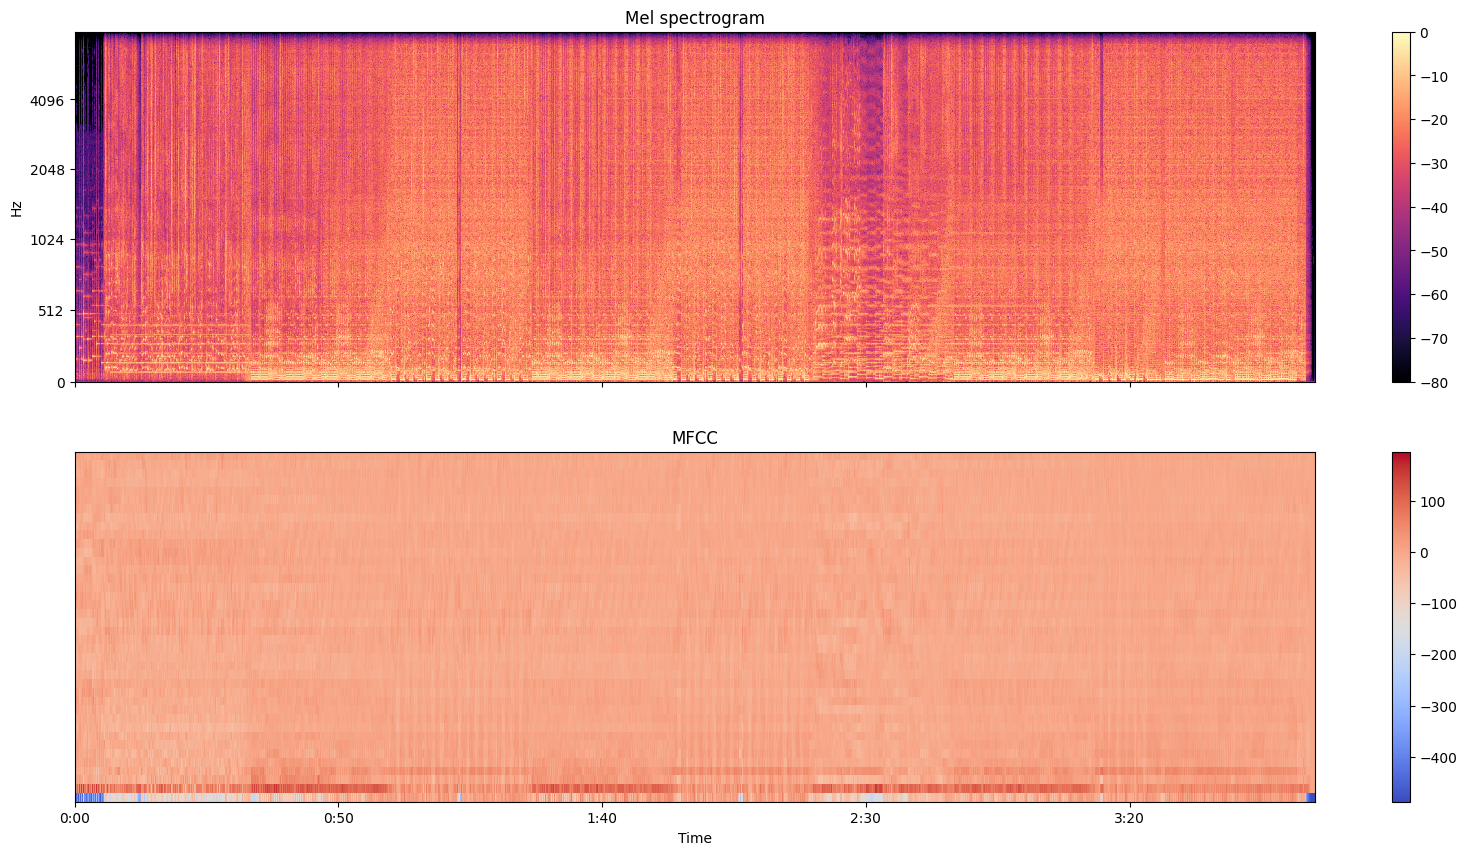

In [44]:
plot_mfcc(mfccs, S)

The mel frequency spectrogram and it's coefficients will help with detecting similar loudness between song portions.

#### Tempogram

Tempogram is a special transformation that detects the speed of the audio sample. The tempogram is shown below:


In [52]:
hop_length = 512

oenv = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)

tempo = librosa.feature.tempo(onset_envelope=oenv, sr=sr,
                              hop_length=hop_length)[0]

In [53]:
def plot_tempogram(oenv, tempogram, tempo):

    fig, ax = plt.subplots(nrows=2, figsize=(20, 10))

    times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)

    ax[0].plot(times, oenv, label='Onset strength')
    ax[0].label_outer()
    ax[0].legend(frameon=True)

    librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,  x_axis='time', y_axis='tempo', cmap='magma', ax=ax[1])

    ax[1].axhline(tempo, color='w', linestyle='--', alpha=1, label='Estimated tempo={:g}'.format(tempo))
    ax[1].legend(loc='upper right')
    ax[1].set(title='Tempogram')

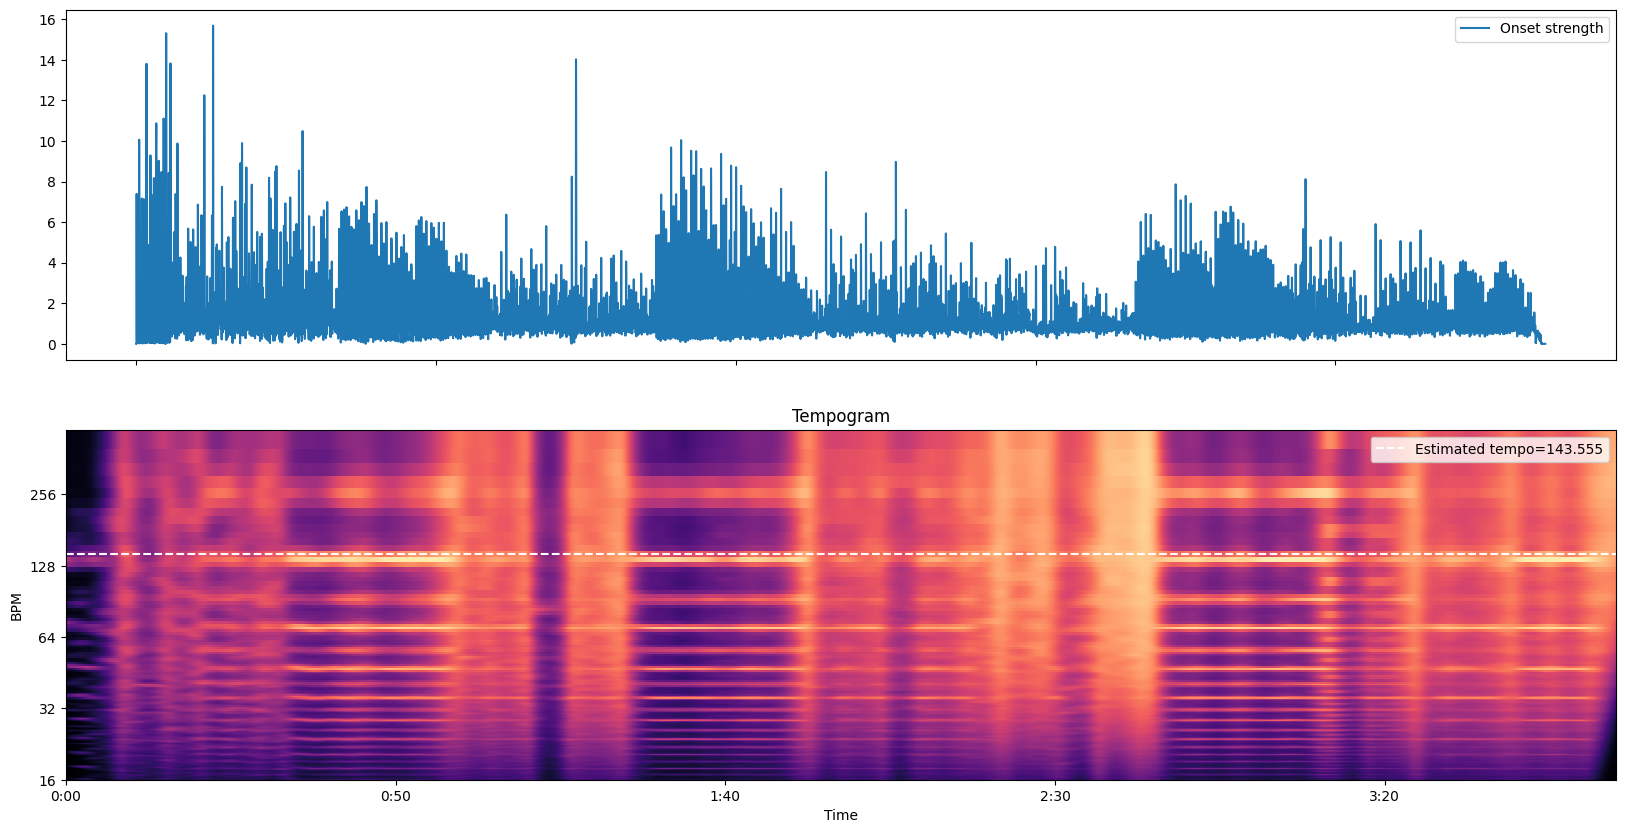

In [55]:
plot_tempogram(oenv, tempogram, tempo)

This feature will help detect the speed of the various songs to be combined.

#### Tempo Ratio

Tempo ratio is a feature that is derived from the tempogram that detects the energy at important multiples of tempo. This aids in detecting rythm of notes. The tempogram ratio is shown below:

[Text(0.5, 1.0, 'Tempogram ratio')]

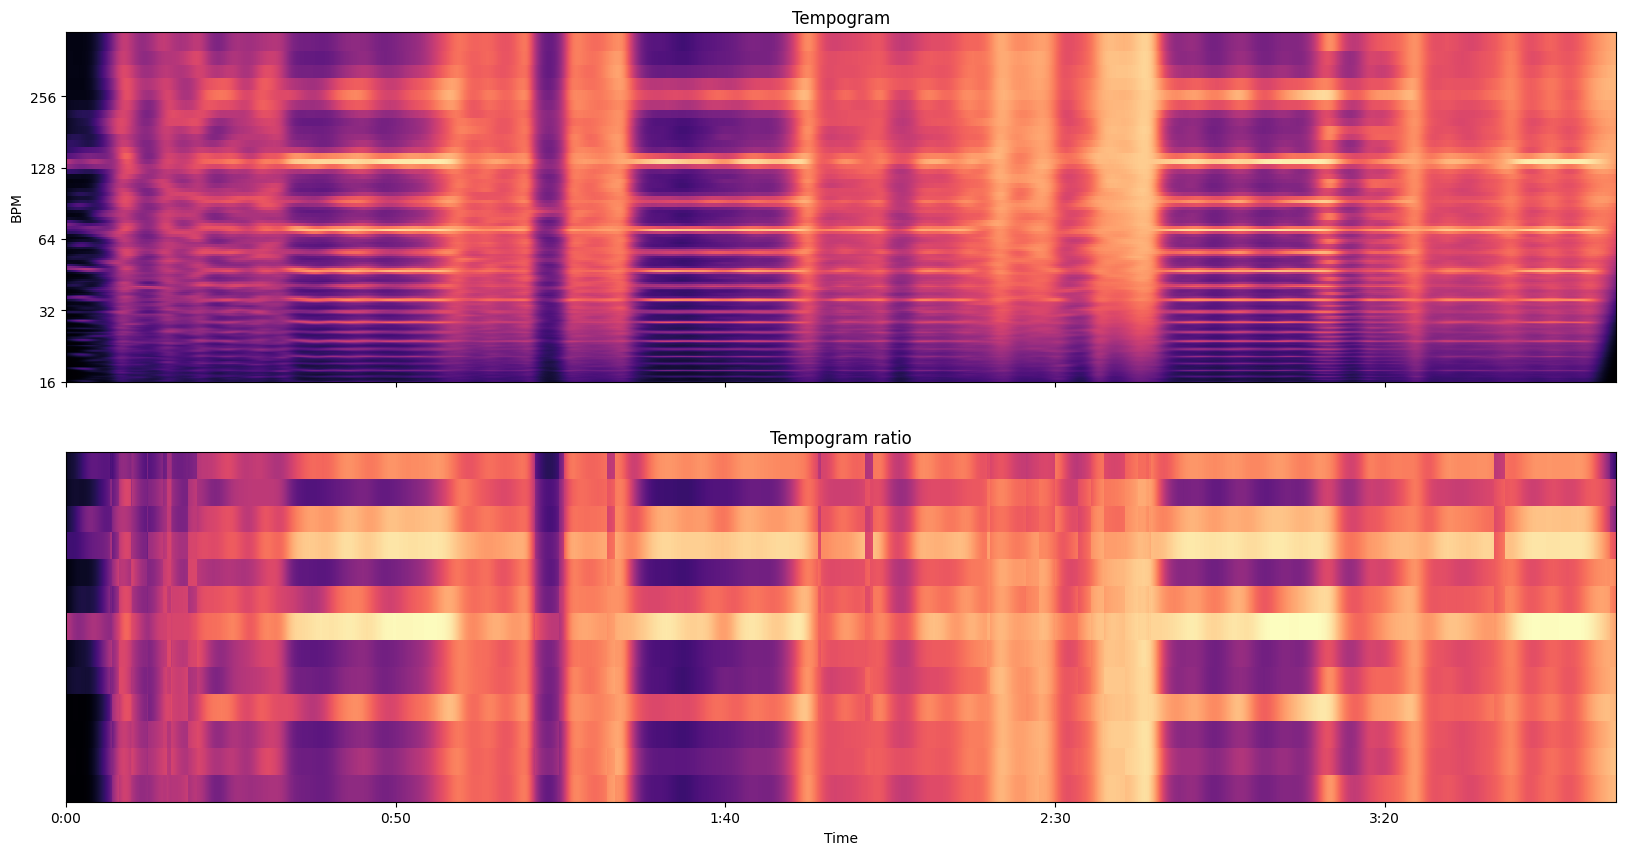

In [57]:
import matplotlib.pyplot as plt

tempogram = librosa.feature.tempogram(y=signal, sr=sr)
tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, sharex=True)

librosa.display.specshow(tempogram, x_axis='time', y_axis='tempo', ax=ax[0])
librosa.display.specshow(tgr, x_axis='time', ax=ax[1])

ax[0].label_outer()
ax[0].set(title="Tempogram")
ax[1].set(title="Tempogram ratio")

The tempogram and tempogram ratio will be tested to check which one captures the flow of the music better.

### Sample Discussion

The four features above are segregated and tested using a nearest neighbor on them. 3 samples are given of each. A final set of samples is included that combines all the features.

##### Chromagram

Seems to capture some level of the melody, but the loudness difference in each song switch is quite dramatic. 

##### MFCCs

Does a good job in combining beats with similar timbres. Once again the switches are pretty dramatic and have some level of discontinuity.

##### Tempogram

Once again, similar rythms are captured but the remaining features have some level of discontinuity.

##### Tempogram ratio

The loudness changes seem more dramatic than the tempogram itself. The rythmic changes do work pretty good. 

##### All Features Combined

With some exceptions, some good transitions are created with a balance of melody-timbre-loudness. More investigation will need to go into combining these features and preprocessing. Additionally, some fading of tracks between transitions will help make the transitions not seem so rough.